### define

Only Lviv-Kyiv & Kyiv-Lviv directions

Parsed 23.05T17 - 26.05T00 every 10-30 min (see sandbox section)

Parsed for all available trains and their wagons for available seats at parsed time

In [1]:
st_id2name = pd.read_csv('./resources/stations.csv').set_index('_id')#['name_en'].to_dict()
print(len(st_id2name))
st_id2name.sample(3)

15441


,name_en,name_ru,name_uk
_id,,,
2048087,Horogochi,Хорогочи,Хорогочи
2004004,Sankt-Peterburg-Finliandskii,Санкт-Петербург-Финлян,Санкт-Петербург-Финлян
2214030,Mykytivka,Никитовка,Микитівка


Schemes of wagons

In [2]:
schemeIds = pd.read_pickle('./resources/schemeIds.pkl')
print(len(schemeIds))
schemeIds.sample(3)

591


train  from  to    wagon_type  reducedComfort  wagon_num
207Л   Lviv  Kyiv  К           False           4            {К01}
092Л   Lviv  Kyiv  К           False           17           {К01}
043Л   Lviv  Kyiv  П           False           12           {П01}
Name: schemeId, dtype: object

Schemes extended

In [3]:
schemes = pd.read_csv('./resources/schemes.tsv', sep='\t').set_index('schemeId')['scheme']
print(len(schemes))
schemes.sample(3)

24


schemeId
П70    {"scheme_type":"П70","model":{"floor":{"1":{"w...
Л60    {"scheme_type":"Л60","model":{"floor":{"1":{"w...
П66    {"scheme_type":"П66","model":{"floor":{"1":{"w...
Name: scheme, dtype: object

Actions for certain `train` + `wagon_type` + `wagon` + `date` per `parsed_time`

In [4]:
presence_df = pd.read_pickle('./resources/presence_df.pkl')
print(len(presence_df))
presence_df

5353


train  wagon_type  wagon_num  date      
001Л   К           1          2019-05-22    {2019-05-22 16:18:34.233000: {'init': {'022', ...
                              2019-05-24    {2019-05-22 16:17:55.359000: {'init': {'016', ...
                              2019-05-26    {2019-05-25 19:33:50.347000: {'init': {'032'}}...
                              2019-05-28    {2019-05-22 16:24:35.378000: {'init': {'006', ...
                   2          2019-05-22    {2019-05-22 16:19:06.829000: {'init': {'016', ...
                              2019-05-24    {2019-05-22 16:17:56.086000: {'init': {'022', ...
                              2019-05-28    {2019-05-22 16:24:41.270000: {'init': {'028', ...
                              2019-05-30    {2019-05-22 17:56:01.082000: {'init': {'024', ...
                   3          2019-05-22    {2019-05-22 16:19:14.999000: {'init': {'016', ...
                              2019-05-24    {2019-05-24 13:50:39.045000: {'init': {'006', ...
                   

## insights

Avarage ahead (future at parsing time) available trains (one direction) at May 22-25 (avg)

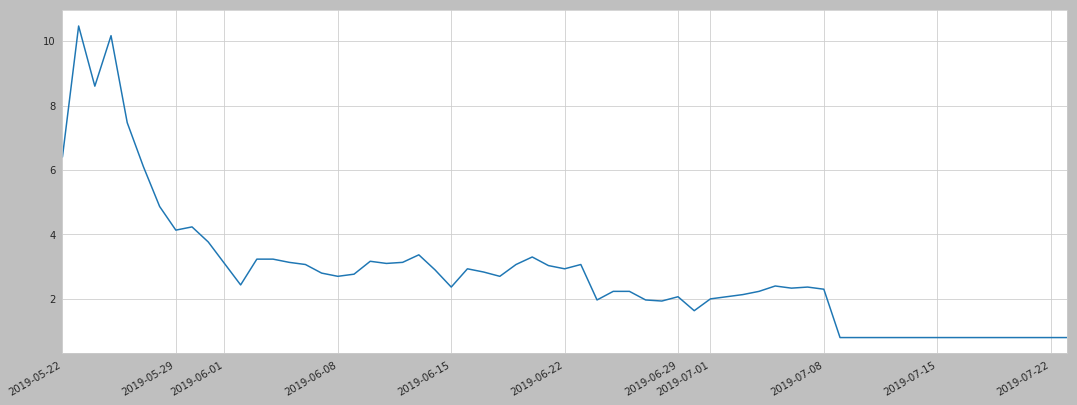

In [5]:
date_s = presence_df.reset_index('date')['date'].value_counts() / 30
date_s.plot();

For near weeks there are more options - clear

Every weekend some gaps have place

No more 2 month ahead

Avarage ahead (future at parsing time) available trains (one direction) at May 22-25 (avg) by day name

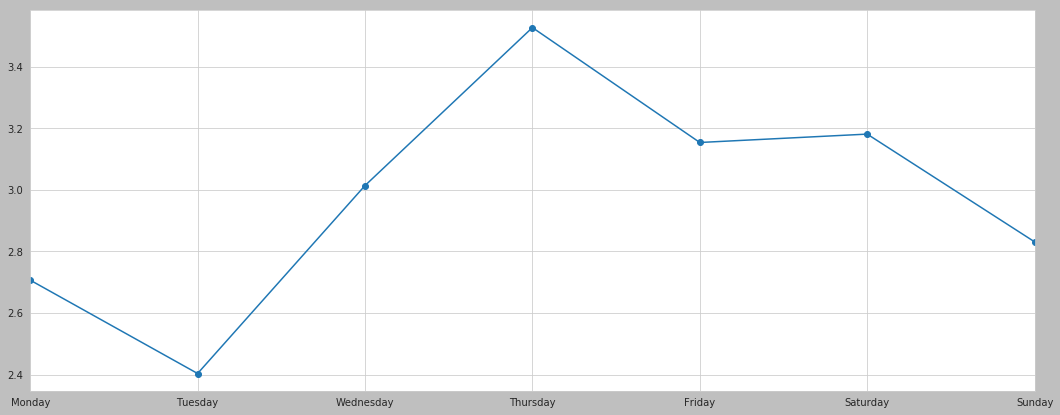

In [6]:
N_WEEKS = 60 / 7

date_s = presence_df.reset_index('date')['date'].map(lambda x: x.day_name()).value_counts() / 30 / N_WEEKS
date_s[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot(marker='o');

Quite logic distibution - Sunday is the most problematic

Friday and Monday have a little bit more options

Saturday isn't so popular, can find tickets with more chance

When people buy (and in which types of wagons)

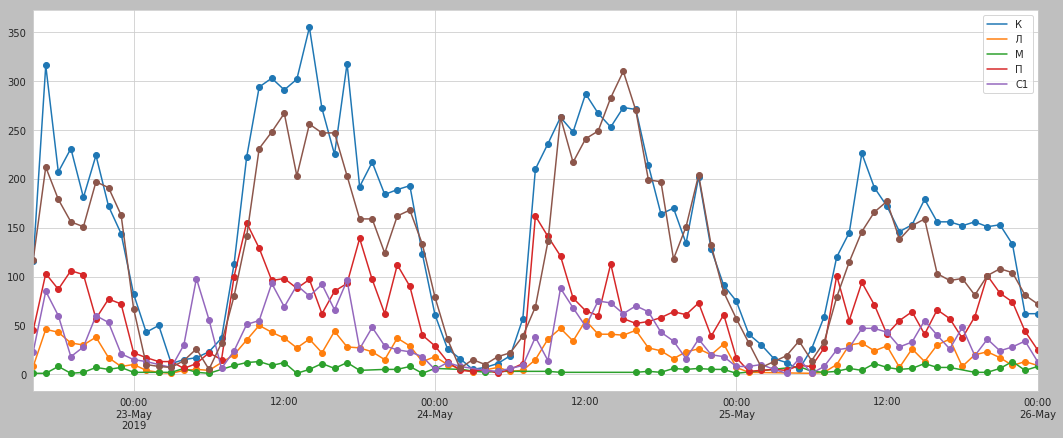

In [7]:
def f(x, hour=False, weekend=None):
    res = defaultdict(int)
    for e in x:
        for t, v in e.items():
            if 'buy' in v:
                d = pd.datetime.strptime(t.strftime('%Y-%m-%d %H'), '%Y-%m-%d %H')
                if weekend:
                    if d <= pd.datetime(2019, 5, 25):
                        continue
                elif weekend == False:
                    if d >= pd.datetime(2019, 5, 25):
                        continue
                if hour:
                    d = d.hour
                res[d] += len(v.get('buy'))
    if hour:
        for k, v in res.items():
            if not weekend:
                if k >= 17:
                    res[k] *= 1/2 if (weekend == False) else 3/4
    return res

types_s = presence_df.groupby('wagon_type').apply(lambda x: f(x, hour=False, weekend=None))
for t in types_s.index.levels[0]:
    plt.legend(types_s.index.levels[0])
    types_s[t].plot(marker='o');

[brown is C2]

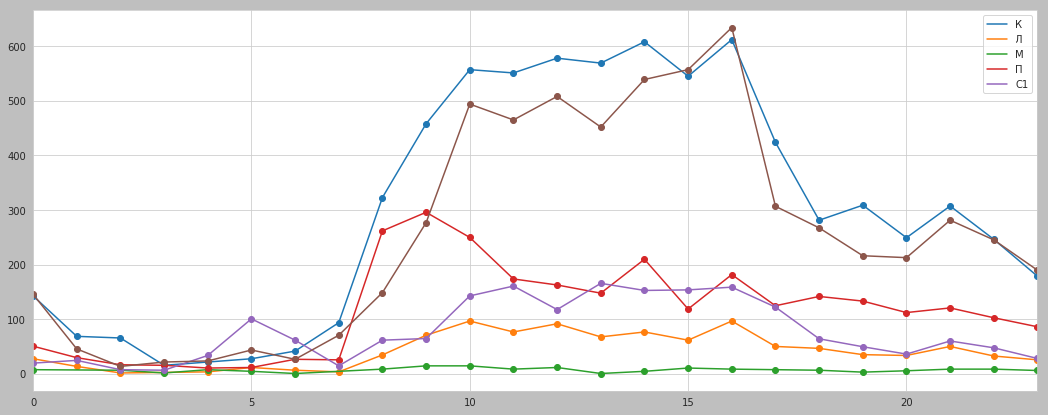

In [8]:
types_s = presence_df.groupby('wagon_type').apply(lambda x: f(x, hour=True, weekend=False))
for t in types_s.index.levels[0]:
    plt.legend(types_s.index.levels[0])
    types_s[t].plot(marker='o');

At workdays 17h+ people usually leave work - no so many actions to but tickets

8 AM - time to buy! (coz new arrival, see sandbox section)

In [9]:
types_s.groupby('wagon_type').sum().sort_values(ascending=False) / types_s.sum()

wagon_type
К     0.376289
С2    0.320037
П     0.145671
С1    0.096347
Л     0.053072
М     0.008583
dtype: float64

15% are using De Luxe (Л) & Seating 1st class (С1), high-paid travel

As well as 15% use cheap Berth, 3-cl. sleeper (П)

~2/3 use Compartment (К) & Seating 2nd class (С2) - moderate price

### prefered seats

In [10]:
presence_df.map(len).groupby(['train', 'wagon_num']).sum().sort_values(ascending=False)[:40]

train  wagon_num
715К   4            399
705К   4            364
743Ш   4            351
744Ш   4            339
743Л   6            325
715К   6            322
       7            318
705Л   4            317
705К   7            312
743Л   3            312
705К   5            312
743Л   7            309
715К   9            296
705Л   6            295
744К   3            295
705Л   7            288
715Л   4            282
705К   6            280
744К   6            280
       7            266
705К   8            253
715Л   6            249
715К   5            249
705К   9            249
705Л   9            241
       5            239
       8            223
715Л   5            221
142П   2            209
715Л   7            206
142Ш   9            205
715Л   9            201
142Ш   4            200
142П   9            197
091К   14           196
715Л   8            195
715К   8            195
092Л   9            192
743Л   2            191
007Л   4            189
dtype: int64

In [11]:
Counter(schemeIds.map(list).sum()).most_common()

[('К01', 194),
 ('П01', 147),
 ('К22', 108),
 ('Л06', 36),
 ('Л20', 29),
 ('К65', 15),
 ('П67', 15),
 ('К56', 12),
 ('П55', 10),
 ('К32', 8),
 ('М02', 8),
 ('П71', 6),
 ('П65', 5),
 ('П66', 5),
 ('П68', 5),
 ('Л60', 4),
 ('П41', 4),
 ('К66', 4),
 ('П70', 4),
 ('К55', 4),
 ('П73', 2),
 ('П72', 2),
 ('К05', 1),
 ('К07', 1)]

In [12]:
schemeIds.map(list).reset_index('wagon_type').groupby('wagon_type')['schemeId'].apply(lambda x: set(sum(x, [])))

wagon_type
К                        {К56, К32, К01, К05, К22, К07}
Л                                       {Л20, Л60, Л06}
М                                                 {М02}
П                                                 {П01}
С1                                      {К55, К65, К66}
С2    {П66, П55, П73, П65, П41, П67, П72, П68, П70, ...
Name: schemeId, dtype: object

So may schemes

For examples choose only one per the most poppular - K, C2 and П

In [13]:
curr_ids = schemeIds[schemeIds.map(lambda x: 'К22' in x)].groupby(['train', 'wagon_type', 'wagon_num']).apply(
    lambda x: x.values[0])
curr_ids = curr_ids.index
curr_ids.shape

(108,)

In [14]:
K22 = []

for i in curr_ids:
    K22 += presence_df[i].values.tolist()
len(K22)

870

Total seats num.

K22 - 40

P01 - 54

P67 - 81

In [15]:
K22_seats = []

for d in K22:
    for t, actions in d.items():
        if 'init' in actions:
            K22_seats += list(set([f"{i:03d}" for i in range(1, 41)]) - actions['init'])
        K22_seats += list(actions.get('buy', set()))
K22_seats = [int(e) for e in K22_seats]
len(K22_seats)

29735

In [16]:
K22_seats_counter = Counter(K22_seats)
K22_seats_counter.most_common()[:10], K22_seats_counter.most_common()[-10:]

([(7, 869),
  (5, 869),
  (15, 861),
  (17, 860),
  (9, 857),
  (11, 857),
  (19, 855),
  (13, 852),
  (3, 837),
  (21, 831)],
 [(24, 686),
  (20, 681),
  (26, 663),
  (30, 624),
  (28, 621),
  (32, 613),
  (34, 582),
  (36, 573),
  (38, 568),
  (40, 511)])

For better opacity viz use `perc**pow`:

K22 - 3

P001 - 4

P067 - 0.5

I did template before ToDo this ↓

In [475]:
with open('./resources/K22.html', 'r') as f:
    html = f.read()
    f.close()
for seat, c in K22_seats_counter.items():
    perc = c/len(K22)
    perc = min(perc, 1)
    html = html.replace(f'px; width: 32px; height: 25px; line-height: 25px;">{seat}</div>',
                        f'px; width: 32px; height: 25px; line-height: 25px; opacity: {perc**3}">{seat}</div>')
    html = html.replace(f'Seat: {seat} ToDo', f'Seat: {seat} was bought in {round(100*perc, 2)} %')
with open('./resources/K22.html', 'w') as f:
    html = f.write(html)
    f.close()

## sandbox

In [17]:
parsed_time = '''2019-05-24 03:20:20 - 1048
2019-05-24 03:31:37 - 1049
2019-05-24 03:44:56 - 1034
2019-05-24 03:56:56 - 1050
2019-05-24 04:09:43 - 1048
2019-05-24 04:23:10 - 1048
2019-05-24 04:36:19 - 1049
2019-05-24 04:49:05 - 1049
2019-05-24 05:02:57 - 1050
2019-05-24 05:16:10 - 1049
2019-05-24 05:28:46 - 1049
2019-05-24 05:38:11 - 1048
2019-05-24 05:47:46 - 1044
2019-05-24 05:57:30 - 1038
2019-05-24 06:08:55 - 1034
2019-05-24 06:21:02 - 1036
2019-05-24 06:34:56 - 1032
2019-05-24 06:49:58 - 1033
2019-05-24 07:05:54 - 1033
2019-05-24 07:21:45 - 1028
2019-05-24 07:38:32 - 1031
2019-05-24 07:54:51 - 1024
2019-05-24 08:15:32 - 1064
2019-05-24 08:36:57 - 1079
2019-05-24 08:57:22 - 1068
2019-05-24 09:19:21 - 1066
2019-05-24 09:41:20 - 1067
2019-05-24 10:04:01 - 1071
2019-05-24 10:27:48 - 1070
2019-05-24 10:52:11 - 1070
2019-05-24 11:17:48 - 1062
2019-05-24 11:41:06 - 1057
2019-05-24 12:07:34 - 1050
2019-05-24 12:32:59 - 1052
2019-05-24 12:56:53 - 1052
2019-05-24 13:22:17 - 1055
2019-05-24 13:46:50 - 1056
2019-05-24 14:13:49 - 1054
2019-05-24 14:40:34 - 1051
2019-05-24 15:08:21 - 1050
2019-05-24 15:34:34 - 1041
2019-05-24 15:57:53 - 1034
2019-05-24 16:23:10 - 1048
2019-05-24 16:49:36 - 1041
2019-05-24 17:14:31 - 1041
2019-05-24 17:41:05 - 1047
2019-05-24 18:13:26 - 1046
2019-05-24 18:43:54 - 1051
2019-05-24 19:10:58 - 1042
2019-05-24 19:40:53 - 1048
2019-05-24 20:09:42 - 1044
2019-05-24 20:35:30 - 1050
2019-05-24 21:00:41 - 1050
2019-05-24 21:24:34 - 1051
2019-05-24 21:49:27 - 1053
2019-05-24 22:16:03 - 1050
2019-05-24 22:40:58 - 1048
2019-05-24 23:03:18 - 1043
2019-05-24 23:23:06 - 1037
2019-05-24 23:43:03 - 1033
2019-05-25 00:03:20 - 1037
2019-05-25 00:21:07 - 1040
2019-05-25 00:38:08 - 1034
2019-05-25 00:53:08 - 1028
2019-05-25 01:06:21 - 912
2019-05-25 01:19:27 - 1029
2019-05-25 01:31:18 - 1033
2019-05-25 01:42:50 - 1040
2019-05-25 01:54:19 - 1044
2019-05-25 02:05:52 - 1044
2019-05-25 02:17:12 - 1045
2019-05-25 02:28:04 - 1043
2019-05-25 02:38:20 - 1045
2019-05-25 02:48:27 - 1045
2019-05-25 02:58:16 - 1045
2019-05-25 03:08:09 - 1043
2019-05-25 03:17:32 - 1044
2019-05-25 03:29:07 - 1045
2019-05-25 03:39:33 - 1039
2019-05-25 03:49:19 - 1041
2019-05-25 03:58:49 - 1046
2019-05-25 04:09:51 - 1045
2019-05-25 04:19:31 - 1045
2019-05-25 04:29:35 - 1045
2019-05-25 04:39:53 - 1042
2019-05-25 04:49:33 - 1045
2019-05-25 04:59:50 - 1046
2019-05-25 05:10:55 - 1045
2019-05-25 05:21:49 - 1042
2019-05-25 05:34:49 - 1043
2019-05-25 05:45:48 - 1044
2019-05-25 05:56:48 - 1043
2019-05-25 06:09:51 - 1039
2019-05-25 06:23:27 - 1032
2019-05-25 06:37:28 - 1033
2019-05-25 06:51:48 - 1038
2019-05-25 07:08:39 - 1030
2019-05-25 07:24:23 - 1021
2019-05-25 07:43:35 - 1020
2019-05-25 08:01:57 - 1027
2019-05-25 08:24:09 - 1064
2019-05-25 08:44:28 - 1068
2019-05-25 09:05:41 - 1057
2019-05-25 09:28:23 - 1067
2019-05-25 09:49:48 - 1066
2019-05-25 10:10:20 - 1061
2019-05-25 10:31:59 - 1062
2019-05-25 10:54:33 - 1059
2019-05-25 11:16:11 - 1062
2019-05-25 11:40:17 - 1059
2019-05-25 12:03:48 - 1055
2019-05-25 12:26:42 - 1055
2019-05-25 12:49:30 - 1054
2019-05-25 13:13:08 - 1053
2019-05-25 13:36:14 - 1044
2019-05-25 13:59:06 - 1049
2019-05-25 14:21:19 - 1046
2019-05-25 14:43:06 - 1040
2019-05-25 15:05:04 - 1046
2019-05-25 15:26:45 - 1038
2019-05-25 15:50:21 - 1043
2019-05-25 16:12:53 - 1046
2019-05-25 16:34:24 - 1047
2019-05-25 16:55:43 - 1047
2019-05-25 17:17:18 - 1049
2019-05-25 17:41:58 - 1046'''.split('\n')
parsed_time = {pd.datetime.strptime(l.split(' - ')[0], '%Y-%m-%d %H:%M:%S'): int(l.split(' - ')[1]) for l in parsed_time}
len(parsed_time)

126

Total unique wagons (both direction, up to 90 days ahead) per iter:

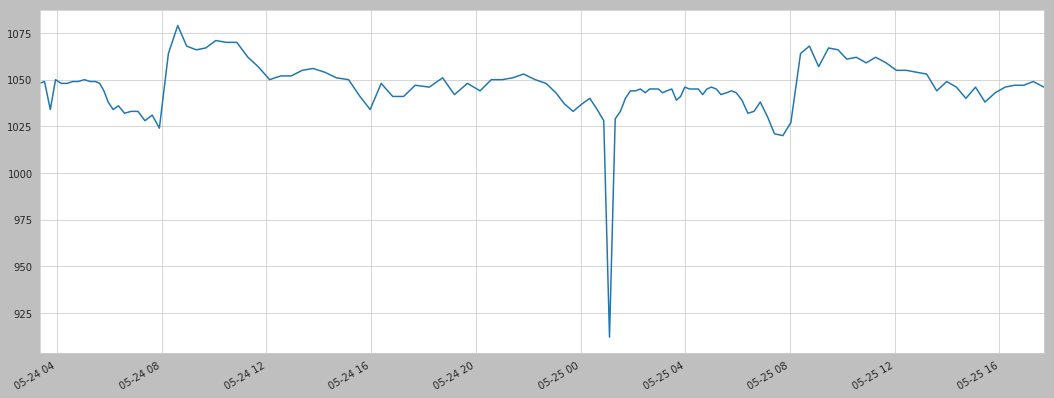

In [18]:
pd.Series(parsed_time).plot();

At 8 AM it seems that new wagons/trains are added

One iter duration:

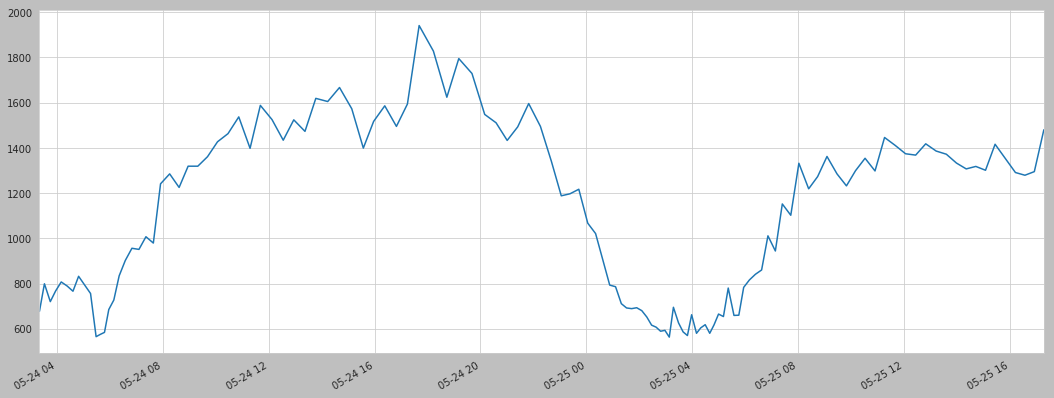

In [19]:
a = list(parsed_time.keys())
a = {a[i]: (a[i+1] - a[i]).seconds for i in range(len(a) - 1)}
pd.Series(a).plot();

In [20]:
unknown_parsed_time = [1057, 1055, 1054, 1053, 1054, 1054, 1054, 1047, 1049, 1044, 1043, 1027, 1045, 1042, 1038, 1040, 1022, 1035, 1038, 1038, 1038,
     1036, 985, 1040, 1039, 1039, 1039, 1039, 1039, 1039, 1037, 1037, 1037, 1038, 1038, 1037, 1036, 1036, 1036, 1036, 1037, 1039,
     1041, 1039, 1039, 1040, 1041, 1041, 1042, 1043, 1042, 1041, 1042, 1041, 1041, 1039, 1039, 1037, 1039, 1040, 1037, 1063, 1070,
     1061, 1063, 1059, 1059, 1055, 1050, 1049, 1041, 1036, 1039, 1039, 1034, 1036, 1036, 1037, 1038, 1042, 1039, 1038, 1043, 1046,
     1047, 1041, 1045, 1044, 1044, 1045, 1046, 1036, 1046, 1044, 1045, 1043, 1040, 1044, 1043, 1040, 1040, 1041, 1043, 1044, 928,
     1047, 1050, 1050, 1049]
len(unknown_parsed_time)

109

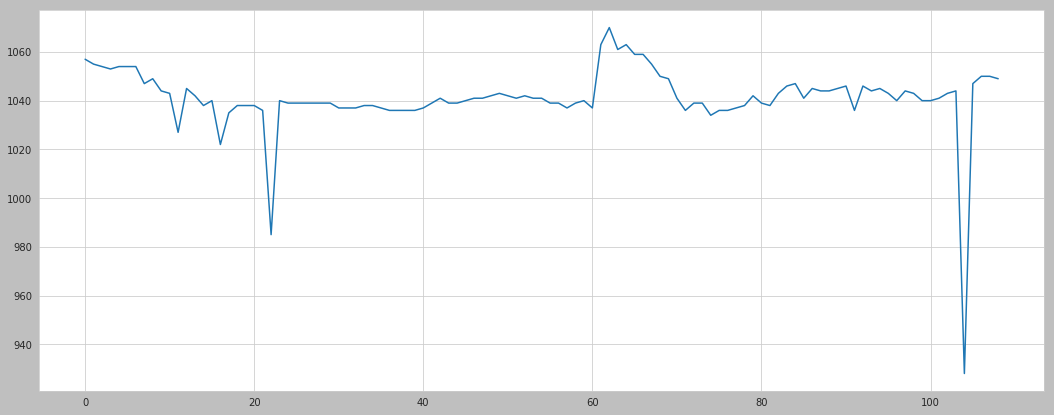

In [21]:
plt.plot(unknown_parsed_time);

## preprocessing

Plain data (~4GB - too much for github)

In [2]:
# df = pd.read_pickle('./resources/all_df.pkl')
print(df.shape)
df.sample(3)

(939628, 13)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 939628 entries, 5ce54b0ac8a1c46c0b676525 to 5ce9bb15b8ff3b2443803786
Data columns (total 13 columns):
date              939628 non-null datetime64[ns]
from              939628 non-null object
parsed_time       939628 non-null datetime64[ns]
places            939628 non-null object
reducedComfort    12467 non-null float64
scheme            939628 non-null object
schemeId          939628 non-null object
to                939628 non-null object
train             939628 non-null object
wagon_num         939628 non-null int64
wagon_type        939628 non-null object
places_types      939628 non-null object
places_left       939628 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(2), object(8)
memory usage: 100.4+ MB


In [4]:
df.describe()

,reducedComfort,wagon_num,places_left
count,12467.0,939628.000000,939628.000000
mean,1.0,6.529469,30.715251
std,0.0,3.105199,26.018059
min,1.0,0.000000,1.000000
25%,1.0,4.000000,7.000000
50%,1.0,6.000000,20.000000
75%,1.0,8.000000,52.000000
max,1.0,34.000000,94.000000


In [ ]:
# df = pd.DataFrame(list(mc['uz']['presence'].find())).set_index('_id')
# df = df.dropna(subset=['places']).drop('ips', 1)
# df['from'] = df['from'].map(st_id2name)
# df['to'] = df['to'].map(st_id2name)
# df['reducedComfort'] = df['reducedComfort'].fillna(0).astype(bool)
# df['places_types'] = df['places'].map(lambda x: list(x.keys()) if isinstance(x, dict) else [])
# df['places'] = df['places'].map(lambda x: sum(x.values(), []) if isinstance(x, dict) else [])
# df['places_left'] = df['places'].map(len)

# df.to_pickle('./resources/all_df.pkl')

# df

In [ ]:

# def f(x):
#     res = defaultdict(dict)
#     n = len(x)
#     res[x[0][0]]['init'] = set(x[0][1])
#     for i in range(1, n):
#         date, places = x[i]
#         places = set(places)
#         prev_places = set(x[i-1][1])
#         n_buy = prev_places - places
#         n_return = places - prev_places
#         if n_buy:
#             res[date]['buy'] = n_buy
#             if len(n_return) & (len(n_return) <= 8):
#                 res[date]['return'] = n_return
#         if len(n_return) & (len(n_return) <= 8):
#             res[date]['return'] = n_return
#     res[x[-1][0]]['exit'] = set(x[-1][1])
#     return dict(res)

# presence_df = df.groupby(['train', 'wagon_type', 'wagon_num', 'date']).apply(
#     lambda date: date[['parsed_time', 'places']].sort_values('parsed_time').values.tolist()
# ).map(f)#.sample(10)
# presence_df.to_pickle('./resources/presence_df.pkl')
# presence_df

## Future work

Todo better communication:)

Better representations

Online presence

Range/category selection

Build-on-go mode

etc.

The MOST part of work - data preprocessing

But interesting project:)

I loved it